In [1]:
%run main.py

instantiation completed in: 2.3754019737243652 [s]
data loaded in: 0.08736300468444824 [s]


-System and Data info-

Available threads: 16
Available memory:  148.08 [GiB]

Ref RA range:    149.880018 to 150.058003
Image RA range:  149.816811 to 150.072298
Ref Dec range:   2.413385 to 2.580602
Image Dec range: 2.347494 to 2.607933
Overlap: True

Ref RA range:    149.880018 to 150.058003
Image RA range:  149.880018 to 150.058003
Ref Dec range:   2.413385 to 2.580602
Image Dec range: 2.413385 to 2.580602
Overlap: True

Ref RA range:    150.010883 to 150.188860
Image RA range:  149.956591 to 150.208951
Ref Dec range:   2.364028 to 2.531243
Image Dec range: 2.297789 to 2.556943
Overlap: True

Ref RA range:    150.010883 to 150.188860
Image RA range:  150.010883 to 150.188860
Ref Dec range:   2.364028 to 2.531243
Image Dec range: 2.364028 to 2.531243
Overlap: True


async process started with 6 workers
preprocessing and background extraction completed in: 117.88118410110474 [s]
async process

# Functions

In [162]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from matplotlib.colors import Normalize
from photutils import aperture
import photutils
from astropy.cosmology import FlatLambdaCDM
import numpy as np

In [3]:
def getcoords(folder):
    file_names = os.listdir(data_dir + folder)
    coords = []
    for name in file_names:
        coord = (int(name.split("_")[0]), int(name.split("_")[1].split(".")[0]))
        coords.append(coord)
    return coords

In [4]:
def pixels_to_radec(wcs_info, pixel_coords, image_shape=None):
    pixel_coords = np.asarray(pixel_coords)
    
    # troubleshooting (I WAS SCHIZO THE PIXEL CONVERSION WORKS!!!, NO J2000 TROLLING!!!)
    if image_shape is not None:
        ny, nx = image_shape
        x, y = pixel_coords[:, 0], pixel_coords[:, 1]
        if np.any(x < 0) or np.any(x >= nx) or np.any(y < 0) or np.any(y >= ny):
            raise ValueError("some pixel coordinates are outside image bounds")
    
    if not isinstance(wcs_info, WCS):
        wcs = WCS(wcs_info)
    else:
        wcs = wcs_info
    
    # (x, y)
    radec = wcs.all_pix2world(pixel_coords, 0)
    
    return radec

In [28]:
def match_to_catalog(input_coords, catalog, dist):
    # create skycoord obj
    cat_coords = SkyCoord(ra=catalog['ALPHA_J2000']*u.deg, 
                          dec=catalog['DELTA_J2000']*u.deg)
    input_coords = SkyCoord(ra=np.array([c[0] for c in input_coords])*u.deg,
                            dec=np.array([c[1] for c in input_coords])*u.deg)
    
    # match
    idx, sep, _ = input_coords.match_to_catalog_sky(cat_coords)
    
    # distance filter
    matches = np.full(len(input_coords), -1)
    valid = sep <= dist*u.arcsec
    matches[valid] = idx[valid]
    
    return matches

In [211]:
def match_to_catalog(input_coords, catalog, dist):
    # create skycoord obj
    cat_coords = SkyCoord(ra=catalog['ALPHA_J2000']*u.deg,
                         dec=catalog['DELTA_J2000']*u.deg)
    input_coords = SkyCoord(ra=np.array([c[0] for c in input_coords])*u.deg,
                           dec=np.array([c[1] for c in input_coords])*u.deg)
    
    # match
    idx, sep, _ = input_coords.match_to_catalog_sky(cat_coords)
    
    # Print the actual separations for debugging
    print("Separations (arcsec):")
    for i, (coord, separation, index) in enumerate(zip(input_coords, sep, idx)):
        print(f"Input {i}: {coord.ra.deg:.6f}, {coord.dec.deg:.6f} → Catalog {index}: sep = {separation.arcsec:.6f} arcsec")
    
    # distance filter
    matches = np.full(len(input_coords), -1)
    valid = sep <= dist*u.arcsec
    matches[valid] = idx[valid]
    
    # verify
    print(f"\nValid match indices: {np.where(valid)[0]}")
    print(f"Matched catalog IDs: {matches[valid]}")
    
    return matches, sep

In [16]:
def get_cutout(fits_file, coords, size=100):
    # this is probably wrong and bad and slow
    from astropy.io import fits
    from astropy.wcs import WCS
    from astropy.coordinates import SkyCoord
    import astropy.units as u

    
    hdul = fits.open(fits_file)
    data = hdul[1].data
    header = hdul[1].header
    wcs = WCS(header)
    
    ra, dec = coords
    target_coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
    
    # mfw i'm converting pixels to radec to pixels
    x, y = wcs.world_to_pixel(target_coord)
    x, y = int(x), int(y)
    
    half_size = size // 2
    x_min = max(0, x - half_size)
    x_max = min(data.shape[1], x + half_size)
    y_min = max(0, y - half_size)
    y_max = min(data.shape[0], y + half_size)
    
    cutout = data[y_min:y_max, x_min:x_max]
    
    hdul.close()

    #plt.clf()
    #plt.imshow(cutout, origin='lower', cmap='magma')
    #plt.colorbar()
    #plt.show()
    
    return cutout


In [203]:
def flux_dist(image_data, position, redshift, aperture_radius=3, background=None):

    #image_data = -image_data
    
    # what
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    
    apt = aperture.CircularAperture(position, r=aperture_radius)
    
    #if background is None:
    #    annulus_aperture = aperture.CircularAnnulus(position, r_in=aperture_radius*1.5, 
    #                                      r_out=aperture_radius*2.5)
    #    annulus_phot = aperture.aperture_photometry(image_data, annulus_aperture)
    #    annulus_area = annulus_aperture.area
    #    background = annulus_phot['aperture_sum'][0] / annulus_area
    
    # photometry
    phot = aperture.aperture_photometry(image_data, apt)
    total_flux = phot['aperture_sum'][0]

    #plt.figure(figsize=(10, 10))
    #plt.imshow(image_data, origin='lower', cmap='viridis')
    #plt.colorbar()
    #plt.plot(position[0], position[1], 'rx', ms=10)
    #plt.title("Image Data")
    #plt.show()
    

    source_flux = total_flux # - background_flux # (bad estimate, breaks things)
    
    print(source_flux)
    apparent_mag = -2.5 * np.log10(source_flux + ε) + zeropoint
    
    distance = cosmo.luminosity_distance(redshift).value  # in Mpc
    distance_modulus = 5 * np.log10(distance * 1e6 / 10 + ε)
    
    absolute_mag = apparent_mag - distance_modulus
    
    # assuming V-band solar absolute mag of 4.83
    luminosity = 10**((4.83 - absolute_mag)/2.5)
    
    return luminosity,distance


In [263]:
def grabinfo(matches, column):
    info = np.array([])
    
    for match in matches:
        info = np.append(info, catalog[column][match])

    return info

In [ ]:
def analysis(coords, catalog, dist, fov, dispfiles, bp, wp):
    matches,sep = match_to_catalog(coords, catalog, dist)

    for i in range(len(matches)):
        plt.clf()
        
        before = get_cutout(data_dir + dispfiles[0], coords[i], size=fov)
        diff = get_cutout(data_dir + dispfiles[1], coords[i], size=fov)
        after = get_cutout(data_dir + dispfiles[2], coords[i], size=fov)
        
        

        glx = matches[i]
        
        if matches[i] != -1:
            gx_coords = [catalog['ALPHA_J2000'][glx], catalog['DELTA_J2000'][glx]]
            lum, dist = flux_dist(diff17, getcoords("transient17")[i], np.mean([catalog['lp_zBEST'][glx], catalog['ez_z_phot'][glx]]))
        else:
            gx_coords = "no associated galaxy"
            lum, dist = "no luminosity calculation possible", "no dist calculation possible"

        print(lum, dist)
        #break
        
        text = f"""
        -------------------------------------------------------------------------------------------------------
        Transient Info
        -------------------------------------------------------------------------------------------------------
        ID: 17-{i}
        Transient coords: {coords[i]}
        Transient luminosity: {lum} [L☉]      
        -------------------------------------------------------------------------------------------------------
        Galaxy Info
        -------------------------------------------------------------------------------------------------------
        Galaxy coords: {gx_coords}
        Visual separation: {sep[i].degree * 3600}"
        Redshift: z={np.mean([catalog['lp_zBEST'][glx], catalog['ez_z_phot'][glx]])}
        -------------------------------------------------------------------------------------------------------
        TDE/AGN
        -------------------------------------------------------------------------------------------------------
        ID_CHANDRA: {catalog['ID_CHANDRA'][glx]}
        lp_type: {catalog['lp_type'][glx]}
        ez_sfr: {catalog['ez_sfr'][glx]}
        lp_SFR_med: {catalog['lp_SFR_med'][glx]}
        ez_mass: {catalog['ez_mass'][glx]}
        lp_mass_med: {catalog['lp_mass_med'][glx]}
        IRAC_CH1_MAG: {catalog['IRAC_CH1_MAG'][glx]}
        SPLASH_CH2_MAG: {catalog['SPLASH_CH2_MAG'][glx]}
        -------------------------------------------------------------------------------------------------------
        SN/VSTAR
        -------------------------------------------------------------------------------------------------------
        HSC_g_MAG_AUTO: {catalog['HSC_g_MAG_AUTO'][glx]}
        HSC_r_MAG_AUTO: {catalog['HSC_r_MAG_AUTO'][glx]}
        HSC_i_MAG_AUTO: {catalog['HSC_i_MAG_AUTO'][glx]}
        """
        
        fig, axes = plt.subplots(
            3, 3, gridspec_kw={"height_ratios": [1, 1.5, 3]},
            figsize=(12,24),
            dpi=200
        )  # 2 rows, 3 columns

        beforenorm = Normalize(vmin=bp, vmax=wp)
        diffnorm = Normalize(vmin=bp, vmax=wp)
        afternorm = Normalize(vmin=bp, vmax=wp)
        
        ax_image1, ax_image2, ax_image3 = axes[0]
        ax_image1.imshow(before, origin='lower', cmap="magma", norm=beforenorm)
        ax_image2.imshow(diff, origin='lower', cmap="magma", norm=diffnorm)
        ax_image3.imshow(after, origin='lower', cmap="magma", norm=afternorm) 

        ax_image1.axis("off")
        ax_image2.axis("off")
        ax_image3.axis("off")
        
        ax_text = axes[1, 0]
        ax_text.text(
            0.01,
            0.99,  # x, y coordinates (0,0 is bottom-left)
            text,
            verticalalignment="top",
            horizontalalignment="left",
            wrap=True,
            fontsize=14,
        )


        ax_text.set_yticklabels([])
        ax_text.set_xticklabels([])
        ax_text.tick_params(axis="both", which="both", length=0)
        ax_text.spines[["top", "right", "bottom", "left"]].set_visible(False)

        for ax in axes[1, 1:]:
            ax.axis("off")


        gs = axes[0, 0].get_gridspec()

        for ax in axes[2, :]:
            ax.remove()

        ax_wide = fig.add_subplot(gs[2, :])

        ax_wide.imshow(get_cutout(data_dir + dispfiles[2], coords[i], size=fov*4), norm=afternorm, cmap="magma")
        ax_wide.axis("off")

        # layout
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.05, wspace=0.05)
        plt.savefig(f"analysis_17/{i}.png", dpi=200)

# Global

In [189]:
zeropoint   = 26.7 # F115 on NIRCAM
pixel_scale = 0.031

catalog = fits.open(data_dir + 'catalog.fits')
catalog = catalog[1].data

ε = 1e-12

# Computations

In [29]:
coords17 = getcoords("transient17")
coords17 = pixels_to_radec(wcs_ref_17, coords17, diff17.shape)
match_to_catalog(coords17, catalog, 0.1) # matches within 1"

array([     -1,      -1, 1171465,      -1,      -1, 1129765, 1197677,
       1102773, 1196107, 1217237,      -1,      -1, 1068804,      -1,
            -1, 1127749, 1147021,      -1,      -1, 1095995])

In [320]:
match17,_ = match_to_catalog(coords17, catalog, 10)

Separations (arcsec):
Input 0: 149.979548, 2.429403 → Catalog 1065675: sep = 1.634556 arcsec
Input 1: 149.903462, 2.461526 → Catalog 1099990: sep = 0.361429 arcsec
Input 2: 149.954150, 2.532022 → Catalog 1171465: sep = 0.048574 arcsec
Input 3: 150.017592, 2.425649 → Catalog 1070495: sep = 0.119007 arcsec
Input 4: 150.049204, 2.521989 → Catalog 1165384: sep = 1.050133 arcsec
Input 5: 149.934686, 2.490511 → Catalog 1129765: sep = 0.074527 arcsec
Input 6: 149.947835, 2.556255 → Catalog 1197677: sep = 0.034985 arcsec
Input 7: 149.904793, 2.464017 → Catalog 1102773: sep = 0.090916 arcsec
Input 8: 149.927315, 2.554637 → Catalog 1196107: sep = 0.042682 arcsec
Input 9: 149.927287, 2.574381 → Catalog 1217237: sep = 0.076568 arcsec
Input 10: 149.936875, 2.553051 → Catalog 1193161: sep = 2.426822 arcsec
Input 11: 149.933287, 2.562199 → Catalog 1203911: sep = 4.079360 arcsec
Input 12: 149.988893, 2.431594 → Catalog 1068804: sep = 0.058877 arcsec
Input 13: 149.900866, 2.463193 → Catalog 1102221: se

In [314]:
coords18 = getcoords("transient18")
coords18 = pixels_to_radec(wcs_ref_18, coords18, diff18.shape)
match18,_ = match_to_catalog(coords18, catalog, 10) # matches within 1"

Separations (arcsec):
Input 0: 150.045452, 2.423329 → Catalog 1059366: sep = 0.068367 arcsec
Input 1: 150.074376, 2.493017 → Catalog 1134129: sep = 0.289348 arcsec
Input 2: 150.077350, 2.394447 → Catalog 1029078: sep = 5.910976 arcsec
Input 3: 150.057473, 2.513498 → Catalog 1154962: sep = 1.565927 arcsec
Input 4: 150.069376, 2.512862 → Catalog 1153009: sep = 2.294592 arcsec
Input 5: 150.017599, 2.425658 → Catalog 1070495: sep = 0.085250 arcsec
Input 6: 150.065951, 2.516836 → Catalog 1158132: sep = 0.730478 arcsec
Input 7: 150.094245, 2.432197 → Catalog 1068928: sep = 2.319689 arcsec
Input 8: 150.160866, 2.427757 → Catalog 1067029: sep = 3.311364 arcsec
Input 9: 150.117191, 2.376459 → Catalog 1010883: sep = 0.223221 arcsec
Input 10: 150.033006, 2.435769 → Catalog 1080852: sep = 1.760674 arcsec
Input 11: 150.066906, 2.418209 → Catalog 1054911: sep = 0.151767 arcsec
Input 12: 150.138832, 2.478039 → Catalog 1119430: sep = 0.577347 arcsec
Input 13: 150.088554, 2.460673 → Catalog 1105714: se

In [323]:
match18

array([1059366, 1134129, 1029078, 1154962, 1153009, 1070495, 1158132,
       1068928, 1067029, 1010883, 1080852, 1054911, 1119430, 1105714,
       1106571, 1122308, 1134664, 1048637])

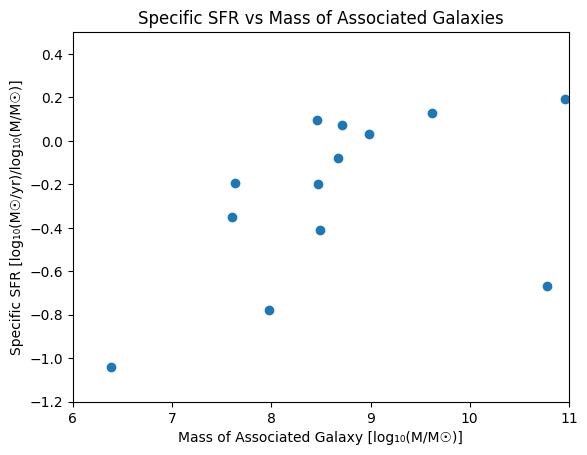

In [305]:
associatedsfr = np.mean(np.array([grabinfo(match17, 'lp_SFR_med'), grabinfo(match17, 'ez_sfr')]), axis=0)
associatedmass = np.mean(np.array([grabinfo(match17, 'lp_mass_med'), grabinfo(match17, 'ez_mass')]), axis=0)
associatedsfr_specific = np.divide(associatedsfr, associatedmass)
plt.scatter(associatedmass, associatedsfr_specific)
plt.xlabel("Mass of Associated Galaxy [log₁₀(M/M☉)]")
plt.ylabel("Specific SFR [log₁₀(M☉/yr)/log₁₀(M/M☉)]")
plt.title("Specific SFR vs Mass of Associated Galaxies")
plt.xlim(6,11)
plt.ylim(-1.2, 0.5)
plt.show()

In [352]:
match17

array([1065675, 1099990, 1171465, 1070495, 1165384, 1129765, 1197677,
       1102773, 1196107, 1217237, 1193161, 1203911, 1068804, 1102221,
       1163544, 1127749, 1147021, 1131182, 1169068, 1095995])

In [333]:
glxmatch17.astype(int)

(16,)

In [328]:
grabinfo(match17, 'lp_SFR_med')

array([ -2.35604,  -2.05033,  -2.36477,       nan,   1.58843,   0.9604 ,
        -6.09112,   0.36674,  -6.08816,  -6.18522,   0.06428,   0.24639,
        -4.94915,  -3.11281,   0.17402,   1.01417,  -1.40123,   0.57082,
         2.10858, -12.20018])

In [335]:
grabinfo(glxmatch18.astype(int), 'lp_SFR_med')

array([-3.16112, -2.02061, -0.58339, -0.24733,  0.87647,      nan,
        1.0697 , -2.06353,      nan, -1.2592 , -0.59985, -4.54237,
        1.00533,      nan,  1.90063,  1.00367,  0.8    ])

[1065675. 1165384. 1102221. 1169068. 1095995. 1029078. 1154962. 1153009.
 1158132. 1080852. 1119430. 1105714. 1122308.]
[1070495. 1102773. 1127749. 1070495.]
[-0.29734899  0.15297177 -0.40884362  0.19325915 -0.66951109 -0.17889562
 -0.04056554  0.10101855  0.09577734  0.00520942  0.09362348         nan
  0.09349932]
[       nan 0.03084759 0.12718136        nan]


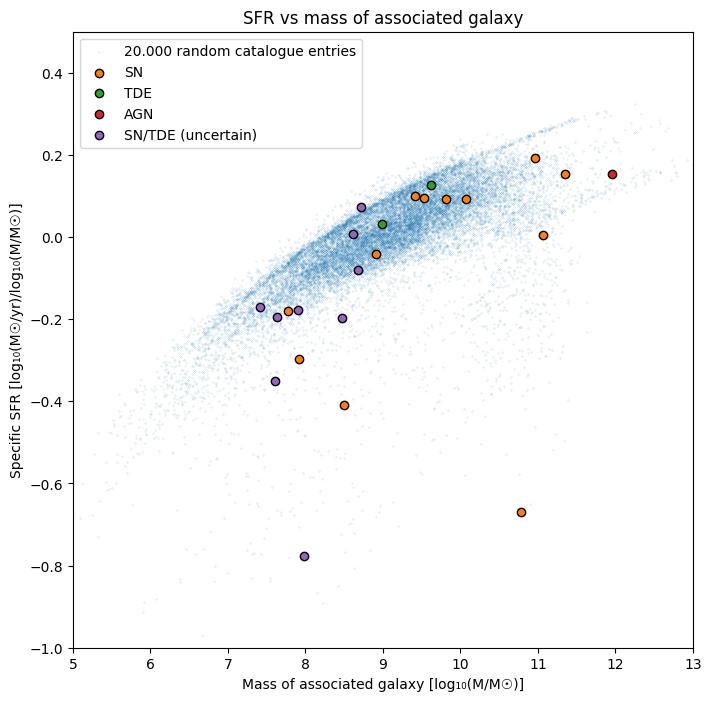

In [374]:
rsample = np.array([1,2,3,4,5,6,7,8,9,10])

for i in range(7):
    rsample = np.append(rsample, rsample*i)

rsample = np.arange(100,20000,1)

associatedsfr = np.mean(np.array([grabinfo(rsample, 'lp_SFR_med'), grabinfo(rsample, 'ez_sfr')]), axis=0)
associatedmass = np.mean(np.array([grabinfo(rsample, 'lp_mass_med'), grabinfo(rsample, 'ez_mass')]), axis=0)
associatedsfr_specific = np.divide(associatedsfr, associatedmass)

for i in range(len(associatedmass)):
    if associatedmass[i] > 1000:
        associatedmass[i] = 0

validindex_17 = [0, 1, 2, 3, 4, 5, 7, 8, 9, 13, 14, 15, 16, 17, 18, 19]
validindex_18 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

glxmatch17 = np.array([])
glxmatch18 = np.array([])
#for i in validindex_17:
#    glxmatch17 = np.append(glxmatch17, int(match17[i]))

#for i in validindex_18:
#    glxmatch18 = np.append(glxmatch18, int(match18[i]))


plt.figure(figsize=(8,8))

plt.scatter(associatedmass, associatedsfr_specific, marker='.', s=0.1, label="20.000 random catalogue entries", alpha=0.5)
plt.xlabel("Mass of associated galaxy [log₁₀(M/M☉)]")
plt.ylabel("Specific SFR [log₁₀(M☉/yr)/log₁₀(M/M☉)]")
plt.title("SFR vs mass of associated galaxy")

#print(match18)

match = match17

for i in match18:
    match = np.append(match, i)
                       
# category separation
sn_index = [0, 4, 13, 18, 19, 22, 23, 24, 26, 30, 32, 33, 35]
tde_index = [3, 7, 15, 25]
agn_index = [31, 36]
other_index = [1, 2, 8, 9, 14, 16, 17, 20, 28, 29]

sn_match = np.array([])
tde_match = np.array([])
agn_match = np.array([])
other_match = np.array([])
for i in sn_index:
    sn_match = np.append(sn_match, match[i])
for i in tde_index:
    tde_match = np.append(tde_match, match[i])
for i in agn_index:
    agn_match = np.append(agn_match, match[i])
for i in other_index:
    other_match = np.append(other_match, match[i])

#sfr1 = np.mean(np.array([grabinfo(glxmatch17.astype(int), 'lp_SFR_med'), grabinfo(glxmatch17.astype(int), 'ez_sfr')]), axis=0)
#sfr2 = np.mean(np.array([grabinfo(glxmatch18.astype(int), 'lp_SFR_med'), grabinfo(glxmatch18.astype(int), 'ez_sfr')]), axis=0)

print(sn_match)
print(tde_match)

sn_associatedsfr = np.mean(np.array([grabinfo(sn_match.astype(int), 'lp_SFR_med'), grabinfo(sn_match.astype(int), 'ez_sfr')]), axis=0)
tde_associatedsfr = np.mean(np.array([grabinfo(tde_match.astype(int), 'lp_SFR_med'), grabinfo(tde_match.astype(int), 'ez_sfr')]), axis=0)
agn_associatedsfr = np.mean(np.array([grabinfo(agn_match.astype(int), 'lp_SFR_med'), grabinfo(agn_match.astype(int), 'ez_sfr')]), axis=0)
other_associatedsfr = np.mean(np.array([grabinfo(other_match.astype(int), 'lp_SFR_med'), grabinfo(other_match.astype(int), 'ez_sfr')]), axis=0)

sn_associatedmass = np.concatenate([np.mean(np.array([grabinfo(sn_match.astype(int), 'lp_mass_med'), grabinfo(sn_match.astype(int), 'ez_mass')]), axis=0), np.mean(np.array([grabinfo(glxmatch18.astype(int), 'lp_mass_med'), grabinfo(glxmatch18.astype(int), 'ez_mass')]), axis=0)])
tde_associatedmass = np.concatenate([np.mean(np.array([grabinfo(tde_match.astype(int), 'lp_mass_med'), grabinfo(tde_match.astype(int), 'ez_mass')]), axis=0), np.mean(np.array([grabinfo(glxmatch18.astype(int), 'lp_mass_med'), grabinfo(glxmatch18.astype(int), 'ez_mass')]), axis=0)])
agn_associatedmass = np.concatenate([np.mean(np.array([grabinfo(agn_match.astype(int), 'lp_mass_med'), grabinfo(agn_match.astype(int), 'ez_mass')]), axis=0), np.mean(np.array([grabinfo(glxmatch18.astype(int), 'lp_mass_med'), grabinfo(glxmatch18.astype(int), 'ez_mass')]), axis=0)])
other_associatedmass = np.concatenate([np.mean(np.array([grabinfo(other_match.astype(int), 'lp_mass_med'), grabinfo(other_match.astype(int), 'ez_mass')]), axis=0), np.mean(np.array([grabinfo(glxmatch18.astype(int), 'lp_mass_med'), grabinfo(glxmatch18.astype(int), 'ez_mass')]), axis=0)])

sn_associatedsfr_specific = np.divide(sn_associatedsfr, sn_associatedmass)
tde_associatedsfr_specific = np.divide(tde_associatedsfr, tde_associatedmass)
agn_associatedsfr_specific = np.divide(agn_associatedsfr, agn_associatedmass)
other_associatedsfr_specific = np.divide(other_associatedsfr, other_associatedmass)

print(sn_associatedsfr_specific)
print(tde_associatedsfr_specific)

plt.scatter(sn_associatedmass, sn_associatedsfr_specific, label="SN", edgecolors='black')
plt.scatter(tde_associatedmass, tde_associatedsfr_specific, label="TDE", edgecolors='black')
plt.scatter(agn_associatedmass, agn_associatedsfr_specific, label="AGN", edgecolors='black')
plt.scatter(other_associatedmass, other_associatedsfr_specific, label="SN/TDE (uncertain)", edgecolors='black')
plt.xlim(5,13)
plt.ylim(-1, 0.5)
plt.legend()
plt.savefig("sfrmass_graph.png", dpi=200)
plt.show()


In [296]:
10**10**19

KeyboardInterrupt: 

In [42]:
coords18 = getcoords("transient18")
coords18 = pixels_to_radec(wcs_ref_18, coords18, diff18.shape)
match_to_catalog(coords18, catalog, 0.1) # matches within 1"

Separations (arcsec):
Input 0: 150.045452, 2.423329 → Catalog 1059366: sep = 0.068367 arcsec
Input 1: 150.074376, 2.493017 → Catalog 1134129: sep = 0.289348 arcsec
Input 2: 150.077350, 2.394447 → Catalog 1029078: sep = 5.910976 arcsec
Input 3: 150.057473, 2.513498 → Catalog 1154962: sep = 1.565927 arcsec
Input 4: 150.069376, 2.512862 → Catalog 1153009: sep = 2.294592 arcsec
Input 5: 150.017599, 2.425658 → Catalog 1070495: sep = 0.085250 arcsec
Input 6: 150.065951, 2.516836 → Catalog 1158132: sep = 0.730478 arcsec
Input 7: 150.094245, 2.432197 → Catalog 1068928: sep = 2.319689 arcsec
Input 8: 150.160866, 2.427757 → Catalog 1067029: sep = 3.311364 arcsec
Input 9: 150.117191, 2.376459 → Catalog 1010883: sep = 0.223221 arcsec
Input 10: 150.033006, 2.435769 → Catalog 1080852: sep = 1.760674 arcsec
Input 11: 150.066906, 2.418209 → Catalog 1054911: sep = 0.151767 arcsec
Input 12: 150.138832, 2.478039 → Catalog 1119430: sep = 0.577347 arcsec
Input 13: 150.088554, 2.460673 → Catalog 1105714: se

(array([1059366,      -1,      -1,      -1,      -1, 1070495,      -1,
             -1,      -1,      -1,      -1,      -1,      -1,      -1,
        1106571,      -1, 1134664,      -1]),
 array([ True, False, False, False, False,  True, False, False, False,
        False, False, False, False, False,  True, False,  True, False]))

In [253]:
len(obj17)+len

Separations (arcsec):
Input 0: 149.979548, 2.429403 → Catalog 1065675: sep = 1.634556 arcsec
Input 1: 149.903462, 2.461526 → Catalog 1099990: sep = 0.361429 arcsec
Input 2: 149.954150, 2.532022 → Catalog 1171465: sep = 0.048574 arcsec
Input 3: 150.017592, 2.425649 → Catalog 1070495: sep = 0.119007 arcsec
Input 4: 150.049204, 2.521989 → Catalog 1165384: sep = 1.050133 arcsec
Input 5: 149.934686, 2.490511 → Catalog 1129765: sep = 0.074527 arcsec
Input 6: 149.947835, 2.556255 → Catalog 1197677: sep = 0.034985 arcsec
Input 7: 149.904793, 2.464017 → Catalog 1102773: sep = 0.090916 arcsec
Input 8: 149.927315, 2.554637 → Catalog 1196107: sep = 0.042682 arcsec
Input 9: 149.927287, 2.574381 → Catalog 1217237: sep = 0.076568 arcsec
Input 10: 149.936875, 2.553051 → Catalog 1193161: sep = 2.426822 arcsec
Input 11: 149.933287, 2.562199 → Catalog 1203911: sep = 4.079360 arcsec
Input 12: 149.988893, 2.431594 → Catalog 1068804: sep = 0.058877 arcsec
Input 13: 149.900866, 2.463193 → Catalog 1102221: se

/tmp/nix-shell-1926-0/ipykernel_30361/895186895.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(


<Figure size 640x480 with 0 Axes>

<Figure size 2400x4800 with 0 Axes>

<Figure size 2400x4800 with 0 Axes>

<Figure size 2400x4800 with 0 Axes>

<Figure size 2400x4800 with 0 Axes>

<Figure size 2400x4800 with 0 Axes>

<Figure size 2400x4800 with 0 Axes>

<Figure size 2400x4800 with 0 Axes>

<Figure size 2400x4800 with 0 Axes>

<Figure size 2400x4800 with 0 Axes>

<Figure size 2400x4800 with 0 Axes>

<Figure size 2400x4800 with 0 Axes>

<Figure size 2400x4800 with 0 Axes>

<Figure size 2400x4800 with 0 Axes>

<Figure size 2400x4800 with 0 Axes>

<Figure size 2400x4800 with 0 Axes>

<Figure size 2400x4800 with 0 Axes>

<Figure size 2400x4800 with 0 Axes>

<Figure size 2400x4800 with 0 Axes>

<Figure size 2400x4800 with 0 Axes>

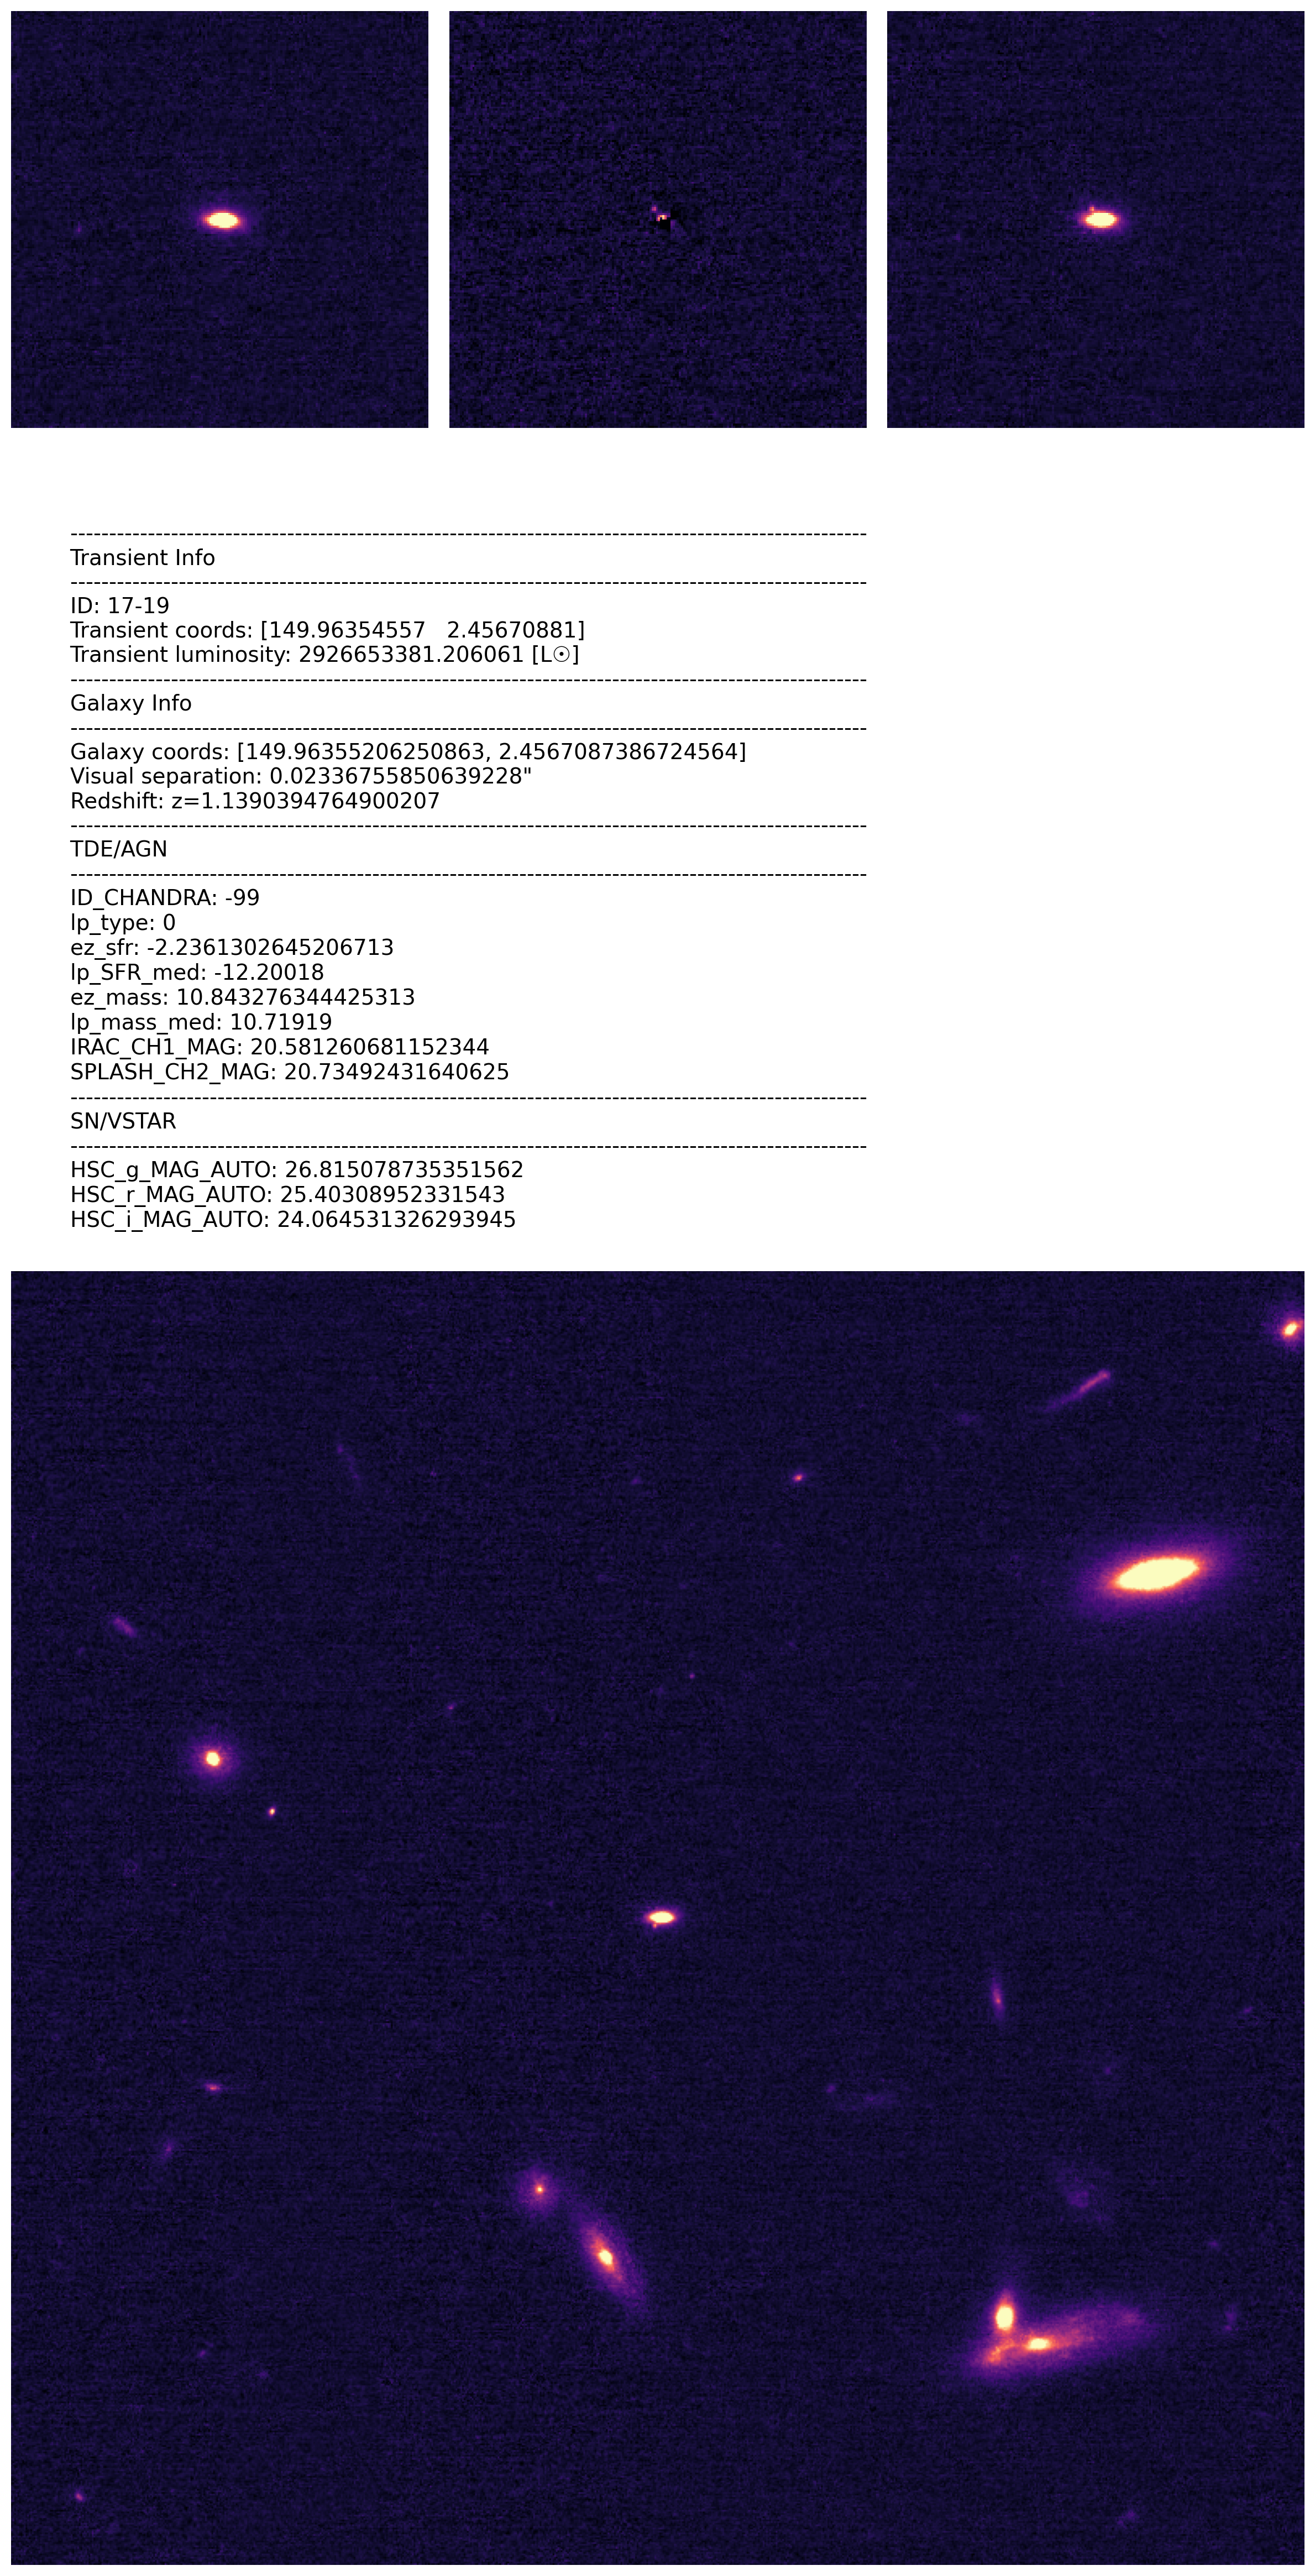

In [254]:
analysis(coords17, catalog, 10, 200, ["cweb-17.fits", "diff-17.fits", "c3d-17.fits"], -0.1, 1)

In [38]:
pixels_to_radec(wcs_ref_18, coords18, diff18.shape)

array([[150.1884245 ,   2.48215997],
       [150.18842387,   2.48215994],
       [150.18842464,   2.48215964],
       [150.18842375,   2.48216013],
       [150.18842373,   2.48216003],
       [150.18842456,   2.4821602 ],
       [150.1884237 ,   2.48216007],
       [150.18842429,   2.48215961],
       [150.18842414,   2.48215908],
       [150.18842467,   2.48215928],
       [150.18842443,   2.48216011],
       [150.18842448,   2.48215979],
       [150.18842381,   2.48215939],
       [150.18842408,   2.48215974],
       [150.18842393,   2.48215942],
       [150.18842373,   2.48215927],
       [150.18842393,   2.48216013],
       [150.18842463,   2.48216009]])

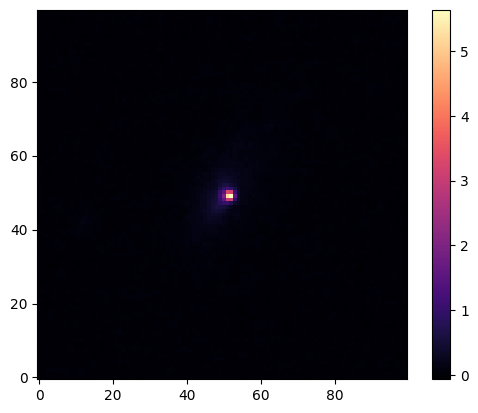

In [50]:
cutout = get_cutout(data_dir + "c3d-18.fits", (150.051009, 2.493831), size=100)

plt.imshow(cutout, origin='lower', cmap='magma')
plt.colorbar()
plt.show()

array([], shape=(0, 11839), dtype='>f4')